# Adversarial Autoencoder

Adversarial autoencoder is regularized by matching the aggregated posterior $q(z)$ to an arbitrary prior distribution $p(z)$. The generator of the adversarial network is also the encoder of the autoencoder $q(z|x)$. The encoder or generator of the network ensures the aggregated posterior distribution can fool the discriminative adversarial network into thinking that the hidden code $q(z)$ comes from the true prior distribution $p(z)$.

Adversarial autoencoder is trained jointly in two phases - reconstruction phase and regularisation phase. In reconstruction phase, autoencoder updates the encoder and decoder to minimise the reconstruction error. In regularisation phase, adversarial network first updates its discriminator to tell apart true samples (generated using the prior $p(z)$) from the generated samples (generated by encoder or generator aggregrated posterior $q(z)$). The adversarial network then updates its generator to confuse the discriminator. Once training is done, decoder will define the generative model that maps the imposed prior $p(z)$ to the data distribution $p_d(x)$



In [1]:
import pickle
import numpy as np
import pandas as pd
import tqdm

# pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

# Arguments

In [72]:
class Args:
    """Dummy argument class
    """
    def __init__(self):
        self.train_batch_size = 100
        self.test_batch_size = 100
        self.seed = 10
        self.no_cuda = True
        self.cuda = not self.no_cuda and torch.cuda.is_available()
        self.epochs = 5
        self.log_interval = 100
    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        attrs = list(self.__dict__.keys())
        for attr in attrs:
             tmpstr = tmpstr + '  ' + attr + ': ' + self.__dict__[attr].__repr__() + '\n'
        tmpstr = tmpstr + ')'
        return tmpstr
# arguments
args = Args()
args

Args (
  train_batch_size: 100
  test_batch_size: 100
  seed: 10
  no_cuda: True
  cuda: False
  epochs: 5
  log_interval: 100
)

In [3]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


# Utility Functions

In [4]:
def plot_mnist_sample(tensor, sample_idx=None, size=10):
    """Plot MNIST samples from tensor.
    """
    # sample from data if sample indices are not provided
    if sample_idx is None:
        # get sample indices
        sample_idx = np.random.uniform(size=size) * tensor.shape[0]
        sample_idx = sample_idx.astype(int)
    # plot data
    nrows = int(np.ceil(len(sample_idx)/10))
    fig, axes = plt.subplots(nrows=nrows, ncols=10, figsize=(20,2))
    for i,s in enumerate(sample_idx):
        ax = axes.item(i)
        ax.imshow(tensor[s].numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Sample Index\n{}".format(s))

# Load MNIST

In [5]:
# transforms.ToTensor converts a PIL.Image or numpy.ndarray (H x W x C) 
# in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in 
# the range [0.0, 1.0]
mnist_train = datasets.MNIST("../data", train=True, download=True,
                             transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True,
                            transform=transforms.ToTensor())

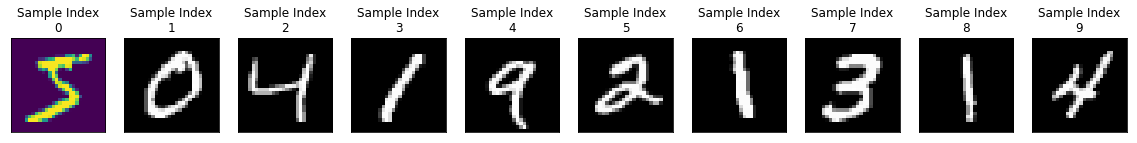

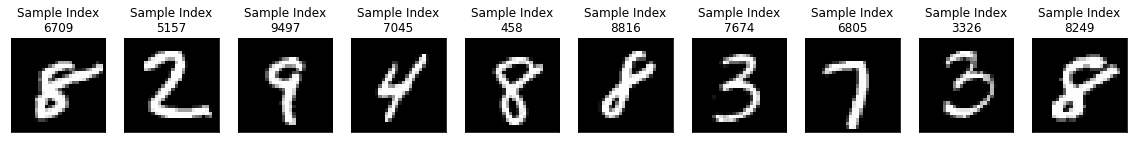

In [6]:
# plot first 10 samples from training data
plot_mnist_sample(mnist_train.train_data, 
                  sample_idx=[i for i in range(10)])
# plot 10 random samples of test data 
plot_mnist_sample(mnist_test.test_data, size=10)


# Check Transformation
- Transform MNIST to [0, 1]
- Check transformation is correct

n.shape: (60000, 28, 28, 1)
torch.Size([1, 28, 28])
Original max values: 255
Transformed max values: 1.0
Reverse back to original, max values: 255
Is original equal to reversed transformed tensor: True


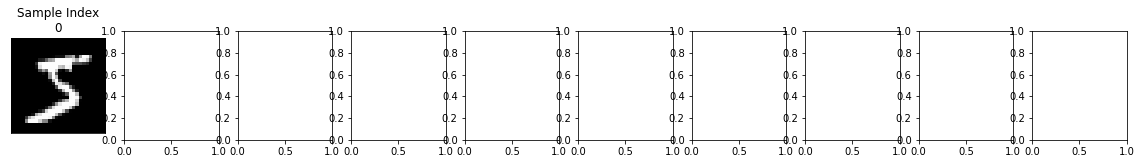

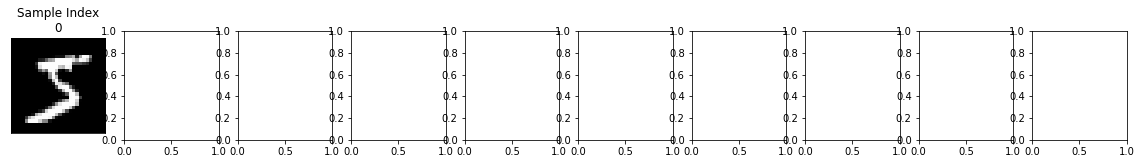

In [7]:
n = mnist_train.train_data.numpy()
n.resize((60000, 28, 28, 1)) # Sample x Height x Width x Channel
print("n.shape:", n.shape) # Sample x Height x Width x Channel

tensor_0 = mnist_train.transform(n[0]) # first sample after transformation
print(tensor_0.size())
# plot first training sample
plot_mnist_sample(tensor_0, sample_idx=[0])
plot_mnist_sample(mnist_train.train_data, sample_idx=[0])

n_0_flatten = n[0, :, :, 0].reshape(784)
print("Original max values:", n_0_flatten.max())
print("Transformed max values:", tensor_0[0, :, :].numpy().max())
tensor_0_flattern_reverse = tensor_0[0, :, :].numpy() * 255
tensor_0_flattern_reverse = tensor_0_flattern_reverse.reshape(784).astype(int)
print("Reverse back to original, max values:", tensor_0_flattern_reverse.max())
print("Is original equal to reversed transformed tensor:",np.equal(n_0_flatten, tensor_0_flattern_reverse).sum() == 784)

# MNIST Data Loader

In [79]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, 
                        batch_size=args.train_batch_size,
                        shuffle=True, 
                        **kwargs)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, 
                        batch_size=args.test_batch_size,
                        shuffle=True, 
                        **kwargs)

# Adversarial Autoencoder Neural Network Modules

In [10]:
x_dim = 784 # input dimension to Encoder
z_dim = 2 # latent space dimension

class Encoder(nn.Module):
    """Encoder of AAE, it extends base class for neural network modules.
    
    Input values to the Encoder are in the range [0.0, 1.0].
    """
    def __init__(self):
        super(Encoder, self).__init__()
        # nn.Linear:
        # Layer of weights and bias that performs linear transformation to incomming data
        # output of each layer: y = Ax + B
        # where A is the weight of the layer and B the bias
        self.lin1 = nn.Linear(x_dim, 1000) # 1000 output dimension with X_dim input dimension 
        self.lin2 = nn.Linear(1000, 1000) # 1000 output dimension with 1000 input dimension
        self.lin3 = nn.Linear(1000, z_dim) # z_dim output dimension from 1000 input dimension
    
    def forward(self, x):
        """Defines the forward computation.
        """
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.relu(x, inplace=False)
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.relu(x, inplace=False)
        return self.lin3(x)

class Decoder(nn.Module):
    """Decoder of AAE, it extends base class for neural network modules.
    
    Output values of Decoder are in the range [0.0, 1.0].
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, x_dim)
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.relu(x, inplace=False)
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = self.lin3(x)
        # ouput values are in range [0.0, 1.0] to match range of input values
        # to the Encoder
        return F.sigmoid(x)

class Discriminator(nn.Module):
    """Discriminator of AAE, it extends base class of neural network modules.
    
    Output of Discriminator is in range [0.0, 1.0]
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.5, training=self.training, inplace=False)
        x = F.relu(x)
        x = self.lin3(x)
        return F.sigmoid(x)

In [61]:
nn_enc = Encoder()
nn_dec = Decoder()
nn_dis = Discriminator()
if args.cuda:
    nn_enc.cuda()
    nn_dec.cuda()
    nn_dis.cuda()

optim_enc = optim.SGD(nn_enc.parameters(), lr=0.05)
optim_dec = optim.SGD(nn_dec.parameters(), lr=0.05)
optim_gen = optim.SGD(nn_enc.parameters(), lr=0.02)
optim_dis = optim.SGD(nn_dis.parameters(), lr=0.01)


In [81]:
for epoch in range(1, args.epochs + 1):
    TINY = 1e-15
    # set networks to training mode
    # this has any effect only on modules such as Dropout or BatchNorm
    nn_enc.train()
    nn_dec.train()
    nn_dis.train()

    total_recon_loss = 0
    total_gen_loss = 0
    total_dis_loss = 0

    for batch_idx, (x, y) in enumerate(mnist_train_loader):
        # resizing data tensor from [batch_size, 1, 28, 28] to [batch_size, 784]
        x = x.view(-1, 784)
        #print(batch_idx, x.shape, y.shape)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x = x.cuda()
            y = y.cuda()

        # reconstruction phase
        # clear the gradients of all optimised variables (of type Variable)
        optim_dec.zero_grad()
        optim_enc.zero_grad()
        z = nn_enc(x)
        recon_x = nn_dec(z)
        recon_loss = F.binary_cross_entropy(recon_x+TINY, x+TINY, weight=None, size_average=True)
        total_recon_loss += recon_loss.data[0]
        # compute gradient of recon_loss Variable
        recon_loss.backward()
        # perform a single optimisation step (parameter update) to decoder
        optim_dec.step()
        # perform a single optimisation step (parameter update) to encoder
        optim_enc.step()

        # regularisation phase
        # clear the gradients of all optimised variables (of type Variable)
        optim_dis.zero_grad()
        optim_gen.zero_grad()
        # sample real z
        # returns a Tensor filled with random numbers from a normal distribution
        # with zero mean and variance of 5
        z_real = Variable(torch.randn(len(x), z_dim) * 5.0)
        if args.cuda:
            z_real = z_real.cuda()
        # set generator network to evaluation mode 
        # this has any effect only on modules such as Dropout or BatchNorm
        nn_enc.eval()
        z_fake = nn_enc(x)
        prob_z_real = nn_dis(z_real)
        prob_z_fake = nn_dis(z_fake)
        dis_loss = -torch.mean(torch.log(prob_z_real+TINY) + 
                               torch.log(1 - prob_z_fake+TINY))
        total_dis_loss += dis_loss.data[0]
        dis_loss.backward()
        optim_dis.step()

        # set generator to training mode
        nn_enc.train()
        z_fake = nn_enc(x)
        prob_z_fake = nn_dis(z_fake)
        gen_loss = -torch.mean(torch.log(prob_z_fake+TINY))
        total_gen_loss += gen_loss.data[0]
        gen_loss.backward()
        optim_gen.step()
        if batch_idx % args.log_interval == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)] recon_loss: {:.6f} dis_loss: {:.6f} gen_loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(mnist_train_loader.dataset),
                100. * batch_idx / len(mnist_train_loader),
                recon_loss.data[0] / len(x),
                dis_loss.data[0] / len(x),
                gen_loss.data[0] / len(x)))

    print('Epoch: {}\n  avg recon_loss: {:.6f}\n  avg dis_loss: {:.6f}\n  avg gen_loss: {:.6f}'.format(
          epoch, total_recon_loss / len(mnist_train_loader.dataset), 
          total_dis_loss / len(mnist_train_loader.dataset),
          total_gen_loss / len(mnist_train_loader.dataset)
         ))

Epoch: 1 [0/60000 (0%)] recon_loss: 0.002587 dis_loss: 0.000332 gen_loss: 0.000030
Epoch: 1 [10000/60000 (17%)] recon_loss: 0.002582 dis_loss: 0.000386 gen_loss: 0.000001
Epoch: 1 [20000/60000 (33%)] recon_loss: 0.002656 dis_loss: 0.000258 gen_loss: 0.000008
Epoch: 1 [30000/60000 (50%)] recon_loss: 0.002547 dis_loss: 0.000456 gen_loss: 0.000004
Epoch: 1 [40000/60000 (67%)] recon_loss: 0.002566 dis_loss: 0.000313 gen_loss: 0.000005
Epoch: 1 [50000/60000 (83%)] recon_loss: 0.002557 dis_loss: 0.000172 gen_loss: 0.000002
Epoch: 1
  avg recon_loss: 0.002576
  avg dis_loss: 0.000179
  avg gen_loss: 0.000005
Epoch: 2 [0/60000 (0%)] recon_loss: 0.002445 dis_loss: 0.000048 gen_loss: 0.000000
Epoch: 2 [10000/60000 (17%)] recon_loss: 0.002518 dis_loss: 0.000663 gen_loss: 0.000002
Epoch: 2 [20000/60000 (33%)] recon_loss: 0.002468 dis_loss: 0.000049 gen_loss: 0.000002
Epoch: 2 [30000/60000 (50%)] recon_loss: 0.002525 dis_loss: 0.000502 gen_loss: 0.000002
Epoch: 2 [40000/60000 (67%)] recon_loss: 0.0

In [73]:
def create_latent(nn_enc, loader):
    '''
    Create the latent representation for the samples in loader
    Return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    nn_enc.eval()
    labels = []
    for batch_idx, (x, y) in enumerate(loader):
        x = x.view(-1, 784)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        labels.extend(y.data.tolist())
        # reconstruction phase
        z = nn_enc(x)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z.data.tolist())))
        else:
            z_values = np.array(z.data.tolist())
    labels = np.array(labels)
    return z_values, labels



# Latent Code of Hold-out Images

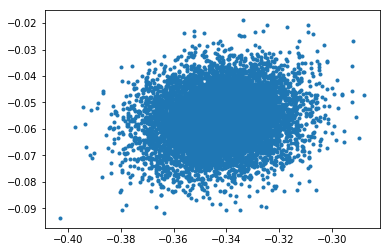

In [82]:
z_values, labels = create_latent(nn_enc, mnist_test_loader)
plt.plot(z_values[:,0], z_values[:,1], ".")